In [17]:
import pandas as pd
import numpy as np 
import seaborn as sns

import matplotlib.pyplot as plt

#from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
pd.set_option('display.max_columns', 50)

## Load data

In [ ]:
df_l = pd.read_csv("data/celeba_buffalo_l.csv")

In [ ]:
df_l_embeddings = df_l.select_dtypes("float")
df_l_features = df_l.select_dtypes("int").drop(columns=["id"])
df_l_images = df_l.loc[:, ["image_name", "id"]]

In [ ]:
df_l_features

## Precomputation

In [ ]:
def correlation_matrix(df: pd.DataFrame) -> None:
	fig = plt.subplots(figsize=(12, 10))
	corr = df.corr().abs()

	mask = np.triu(np.ones_like(corr, dtype=bool))
	sns.heatmap(corr, mask=mask, cmap="magma", square=True, vmin=0, vmax=1, center=0, annot=False)

correlation_matrix(df_l_features)

In [ ]:
corr = df_l_features.corr().abs()
corr

In [ ]:
upper = np.triu(np.ones(corr.shape, dtype=bool), k=1)
upper = corr.where(upper)

to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]
print(to_drop)

df_l_features.drop(columns=to_drop, axis=1, inplace=True)

In [ ]:
to_drop

In [ ]:
df_l_embeddings

## DR

In [ ]:
pca = PCA(n_components=50)
df_l_embeddings_pca_50d = pca.fit_transform(df_l_embeddings)

In [ ]:
pca = PCA(n_components=2)
df_l_embeddings_pca_2d = pca.fit_transform(df_l_embeddings_pca_50d)
plt.scatter(x=df_l_embeddings_pca_2d[:,0], y=df_l_embeddings_pca_2d[:,1])

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit_transform(df_l_embeddings_pca_2d)

In [ ]:
tsne = TSNE(n_components=2)
df_l_embeddings_2d = tsne.fit_transform(df_l_embeddings)

plt.scatter(x=df_l_embeddings_2d[0], y=df_l_embeddings_2d[1])

In [27]:
df_l_embeddings_2d

array([[-1,  1, -1, ..., -1, -1,  1],
       [-1, -1, -1, ...,  1, -1,  1],
       [-1,  1, -1, ..., -1, -1,  1],
       ...,
       [-1, -1, -1, ...,  1, -1,  1],
       [-1,  1, -1, ...,  1, -1,  1],
       [-1,  1, -1, ..., -1, -1,  1]])

In [29]:
from openTSNE import TSNE

tsne = TSNE(
	perplexity=30,
	n_jobs=2,
	random_state=42,
	verbose=True
)
res = tsne.fit(np.array(df_l_features))

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=2, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 13.35 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.11 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.11 seconds
===> Running optimization with exaggeration=12.00, lr=2501.00 for 250 iterations...
Iteration   50, KL divergence 5.7818, 50 iterations in 3.5504 sec
Iteration  100, KL divergence 5.8694, 50 iterations in 4.2886 sec
Iteration  150, KL divergence 5.8689, 50 iterations in 4.8743 sec
Iteration  200, KL divergence 5.8689, 50 iterations in 4.8974 sec
Iteration  250, KL divergence 5.8689, 50 iterations in 7.0952 sec
   --> Time elapsed: 24.71 seconds
===> Running optimization with exaggeration

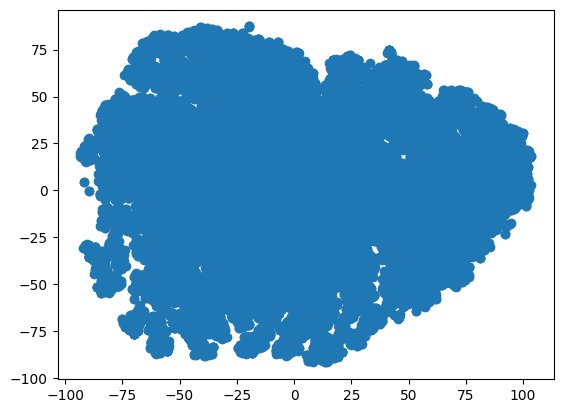

In [31]:
plt.scatter(x = res[:,0], y = res[:,1])

## Clustering

In [ ]:
df_s = pd.read_csv("data/celeba_buffalo_s.csv")
df_s.head(5)

In [ ]:
%%time
selected_features = ["5_o_Clock_Shadow", "Arched_Eyebrows"]
features_mask = df_l_features[selected_features].isin([1]).all(axis=1)

df_l_images[features_mask].loc[:, "image_name"][0:10]

In [ ]:
%%time
df_l_features_dict = df_l_features.to_dict("records")
df_l_features_dict

In [ ]:
df_l_features_dict

In [ ]:
df_s_embeddings = df_s.select_dtypes("float")
df_s_features = df_s.select_dtypes("int").drop(columns=["id"])
df_s_images = df_s.loc[:, ["image_name", "id"]]

# df_s_embeddings.to_parquet("data/celeba_buffalo_s__embeddings.gzip")
# df_s_embeddings.to_csv("data/celeba_buffalo_s__embeddings.csv")
# df_s_features.to_parquet("data/celeba_buffalo_s__features.gzip")
# df_s_images.to_parquet("data/celeba_buffalo_s__images.gzip")

In [ ]:
features.columns.to_list()

In [ ]:
FEATURE = "Eyeglasses"

def histogram_of_feature(df, feature: str):
	ax = df[feature].replace({-1: "no", 1: "yes"}).hist(bins=3, rwidth=0.8, alpha=0.6, color="c")
	
	ax.set_xlabel("Features")
	ax.set_ylabel("Frequency")
	ax.set_title(f"Histogram of {FEATURE}")

histogram_of_feature(features, FEATURE)

In [ ]:
def feature_presence_counter(df):
	#df[feature].replace({-1: "no", 1: "yes"}).unique()
	counts = pd.DataFrame({col: df[col].value_counts() for col in df})
	counts = counts.iloc[1]
	counts = counts.sort_values(ascending=False)
	counts = pd.DataFrame(counts).reset_index()
	counts.columns = ["Feature", "Count"]
	return counts

feature_presence_counter(df_l_features)

In [ ]:
def feature_presence_couter_plot(df):
	counts = pd.DataFrame({col: df[col].value_counts() for col in df})
	counts = counts.iloc[1]
	counts = counts.sort_values(ascending=False)

	fig, ax = plt.subplots(figsize=(8, 6))
	counts.plot(kind="bar", ax=ax)

	ax.set_title("Most present features")
	ax.set_xlabel("Feature")
	ax.set_ylabel("Count")

feature_presence_couter_plot(features)

In [ ]:
feature_presence_couter_plot(subset2)

In [ ]:
def correlation_between_feature(df):
	fig = plt.subplots(figsize=(12, 10))
	corr = df.corr().abs()

	mask = np.triu(np.ones_like(corr, dtype=bool))
	sns.heatmap(corr, mask=mask, cmap="magma", square=True, vmin=0, vmax=1, center=0, annot=False)

In [ ]:
correlation_between_feature(features)

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="No_Beard", y="embedding_0", data=df1, palette="Set3")

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="No_Beard", y="embedding_0", data=df2, palette="Set3")